## Import packages

In [1]:
import os
from collections import OrderedDict as ordict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns                                # $:~ conda install seaborn
import scipy.stats as stats
import scipy.optimize as opt

%matplotlib inline

## Style settings

In [2]:
sns.set_style('white')
sns.set_context('paper')
sns.set_palette(sns.dark_palette('blue'))

matplotlib.rcParams['xtick.labelsize'] = 30 # 30 = 14 (abstract = poster)
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['axes.labelsize'] = 35 # 35 = 16
matplotlib.rcParams['legend.fontsize'] = 30
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

greens = sns.cubehelix_palette(n_colors=5, start=2.0, rot=.2, gamma=1, hue=.8, light=.8, dark=.15)
reds = sns.cubehelix_palette(n_colors=3, start=0.8, rot=.1, gamma=.7, hue=2, light=.7, dark=.15)

colorlist = [greens, reds]
sns.set_palette(greens)

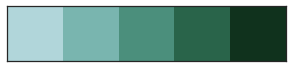

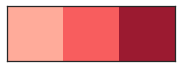

In [3]:
sns.palplot(greens)
sns.palplot(reds)

## Load Data

In [36]:
# DO NOT put data into github folders!

gdpath = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
figdir = os.path.join(gdpath, 'Presentations/201702 Cosyne 2017/Figures')# 'Manuscripts/Cosyne2017Abstract/Figures') # for abstract

params_lrn = pd.read_csv(os.path.join(gdpath, 'Analysis/3_lrn/params_learn_final.csv'))
params_tai = pd.read_csv(os.path.join(gdpath, 'Analysis/5_tai/params_tai_final.csv'))

In [37]:
params_tai['condition'] = params_tai['condition'].map({0: 5, 1: 10, 2:20})
params_tai['rt'] = params_tai['rt']/1000
params_lrn['rt'] = params_lrn['rt']/1000

mean_correction_fields = [
    'elo', 'tree_size', 'attention', 'rt', 'lapse', 'act_scale', 'prune_thresh', 
    'value_quality', 'weight_center', 'weight_2conn', 'weight_2unc', 'weight_3', 'weight_4'
]

mean_correction_labels = ['mc ' + i for i in mean_correction_fields]

for i, p in enumerate([params_tai, params_lrn]):
    for val in mean_correction_fields:
        if val in p.columns:
            nv = 'mc ' + val
            mean_correction_labels.append(nv)
            mean_elos = p.pivot_table(index='subject', values=val) # note to self: rename this to not be confusing!
            for i in p.subject.unique():
                p.loc[p.subject==i, nv] = p.loc[p.subject==i, val] - mean_elos[i]
            p[nv] = p[nv].fillna(method='ffill')
            
pl = params_lrn.groupby(['subject', 'session']).mean().reset_index()
pt = params_tai.groupby(['subject', 'condition']).mean().reset_index()

In [6]:
def get_corr_table(df, regressor_label):
    S = pd.DataFrame(index=mean_correction_labels, columns=['r', 'p'])
    for m in S.index:
        res = stats.linregress(df[regressor_label], df[m])
        S.loc[m, ['r', 'p']] = res.rvalue, res.pvalue
        
    return S

In [7]:
tai_corrs = dict()
for s in ['condition', 'mc rt', 'mc elo']:
    S = get_corr_table(params_tai, s)
    S.to_csv(os.path.join(gdpath, 'Analysis/5_tai/correlations/{}.csv'.format(s)))
    tai_corrs[s] = S

lrn_corrs = dict()
for s in ['session', 'mc elo', 'mc rt']:
    S = get_corr_table(params_lrn, s)
    S.to_csv(os.path.join(gdpath, 'Analysis/3_lrn/correlations/{}.csv'.format(s)))
    lrn_corrs[s] = S

# Final plots

In [194]:
errkws = {'linewidth': 3.8}
def format_regression_text(res):
    if res.pvalue < .001:
        pval = .001
    elif res.pvalue < .01:
        pval = .01
    elif res.pvalue < .05:
        pval = .05
    else:
        pval = res.pvalue

    if res.pvalue < .01:
        textstring = 'p < {:.3f}, r = {:.2f}'
    elif res.pvalue < .05:
        textstring = 'p < {:.2f}, r = {:.2f}'
    else:
        textstring = 'p = {:.2f}, r = {:.2f}'

    textstring = textstring.format(pval, res.rvalue)

    return textstring

def curve_like_plot(param, experiment, ax=None, scatterkws=scatterkws, errkws=errkws, lineon=True, texton=False):
    if experiment == 'learning':
        split = 'session'
        colors = greens
        df = params_lrn
    elif experiment == 'timed':
        split = 'condition'
        colors = reds
        df = params_tai
            
    y = df.pivot_table(index=split, values=param, aggfunc=np.mean)
    yinterval = df.pivot_table(index=split, values=param, aggfunc=lambda x: 1.96*stats.sem(x))
    
    if lineon:
        ax.plot(y.index, y.values, color='black')
    
    if texton:
        res = stats.linregress(df[split], df[param])
        textstring = format_regression_text(res)
        ax.text(0.04, 0.03, textstring, fontsize=29, transform=ax.transAxes)
        
    for ii, i in enumerate(df[split].unique()):
        ax.plot(i, y[i], color=colors[ii], **scatterkws)
        ax.errorbar(i, y[i], yinterval[i], color=colors[ii], **errkws)
        
    return None

def scatter_plot(param1, param2, experiment, ax=None, reduce=False, lineon=False, texton=False, textloc='bottom', scatterkws=scatterkws):
    if experiment == 'learning':
        split = 'session'
        colors = greens
        df = pl if reduce else params_lrn
    elif experiment == 'timed':
        split = 'condition'
        colors = reds
        df = pt if reduce else params_tai
        
    if lineon:
        pass
    
    if texton:
        res = stats.linregress(df[param1], df[param2])
        textstring = format_regression_text(res)
        texty = .03 if textloc=='bottom' else .95
        ax.text(0.04, texty, textstring, fontsize=29, transform=ax.transAxes)
        
    for ii, i in enumerate(df[split].unique()):
        p = df.loc[df[split]==i]
        ax.plot(p[param1], p[param2], color=colors[ii], **scatterkws)
        
    return None

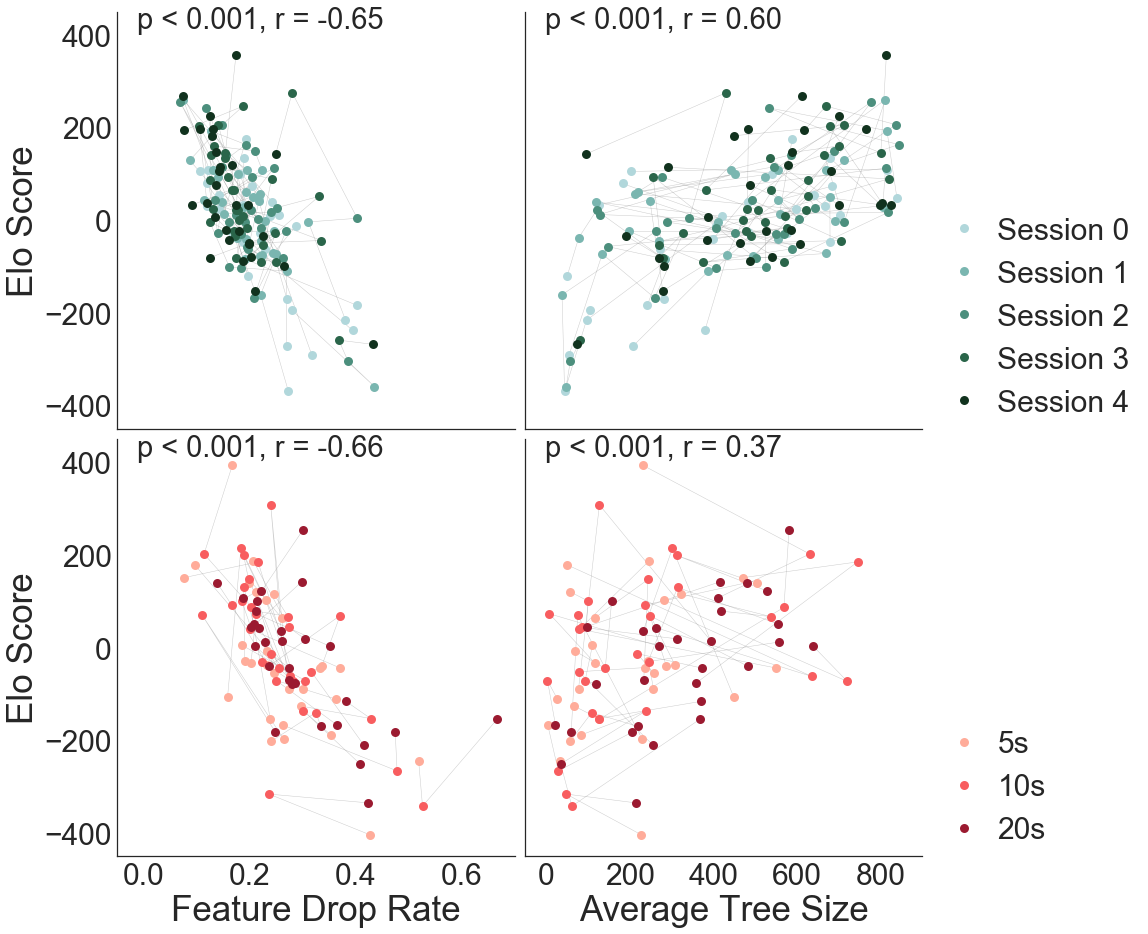

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharey=True)
lineplotkws = {'linewidth': .5, 'alpha': .4, 'color': 'grey', 'label': 'none'}
scatterkws = {'linestyle': 'none', 'marker': 'o', 'markersize': 9}

divtypes = ['session', 'condition']
divlabels = ['Session {}', '{}s']
variables = ordict([('Feature Drop Rate', 'attention'), ('Tree Size', 'tree_size')])
legs = []

for e, experiment in enumerate([pl, pt]):
    for i, key in enumerate(variables.keys()):
        val = variables[key]
        ax = axes[e, i]
        div = divtypes[e]
        colors = [greens, reds][e]
        
        for j in experiment['subject'].unique():
            pdata = experiment.loc[experiment['subject']==j, :]
            ax.plot(pdata[val], pdata['elo'], **lineplotkws)
        
        for l, j in enumerate(experiment[div].unique()):
            pdata = experiment.loc[experiment[div]==j, :]
            c, la = colors[l], divlabels[e].format(j)
            ax.plot(pdata[val], pdata['elo'], color=c, label=la, **scatterkws)
            
        if i==1: 
            leg = ordict(zip(*ax.get_legend_handles_labels())).items()
            leg = ordict([(k, v) for k, v in leg if v != 'none'])
            leg = ax.legend(leg.keys(), leg.values(), loc=(1,0), handletextpad=0.1)
            legs.append(leg)
            
        res = stats.linregress(experiment[val], experiment['elo'])
        x = .05 if i == 0 else 20
        pvaltext = res.pvalue if res.pvalue > .0005 else .001
        textstring = 'p < {:.3f}, r = {:.2f}'.format(pvaltext, res.rvalue)
        ax.text(.05, .96, textstring, fontsize=29, transform=ax.transAxes)

plt.setp(
    axes[:, 0],
    ylabel='Elo Score', ylim=[-450, 450], yticks=np.arange(-400, 500, 200),
    xlim=[-.05, .7], xticks=np.arange(0, .8, .2)
)

plt.setp(axes[:, 1], xlim=[-50, 900], xticks=np.arange(0, 1050, 200))
plt.setp(axes[0, :], xticks=[])
axes[1, 0].set_xlabel('Feature Drop Rate')
axes[1, 1].set_xlabel('Average Tree Size')

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'Elo vs Params.png'), bbox_extra_artists=legs, bbox_inches='tight')

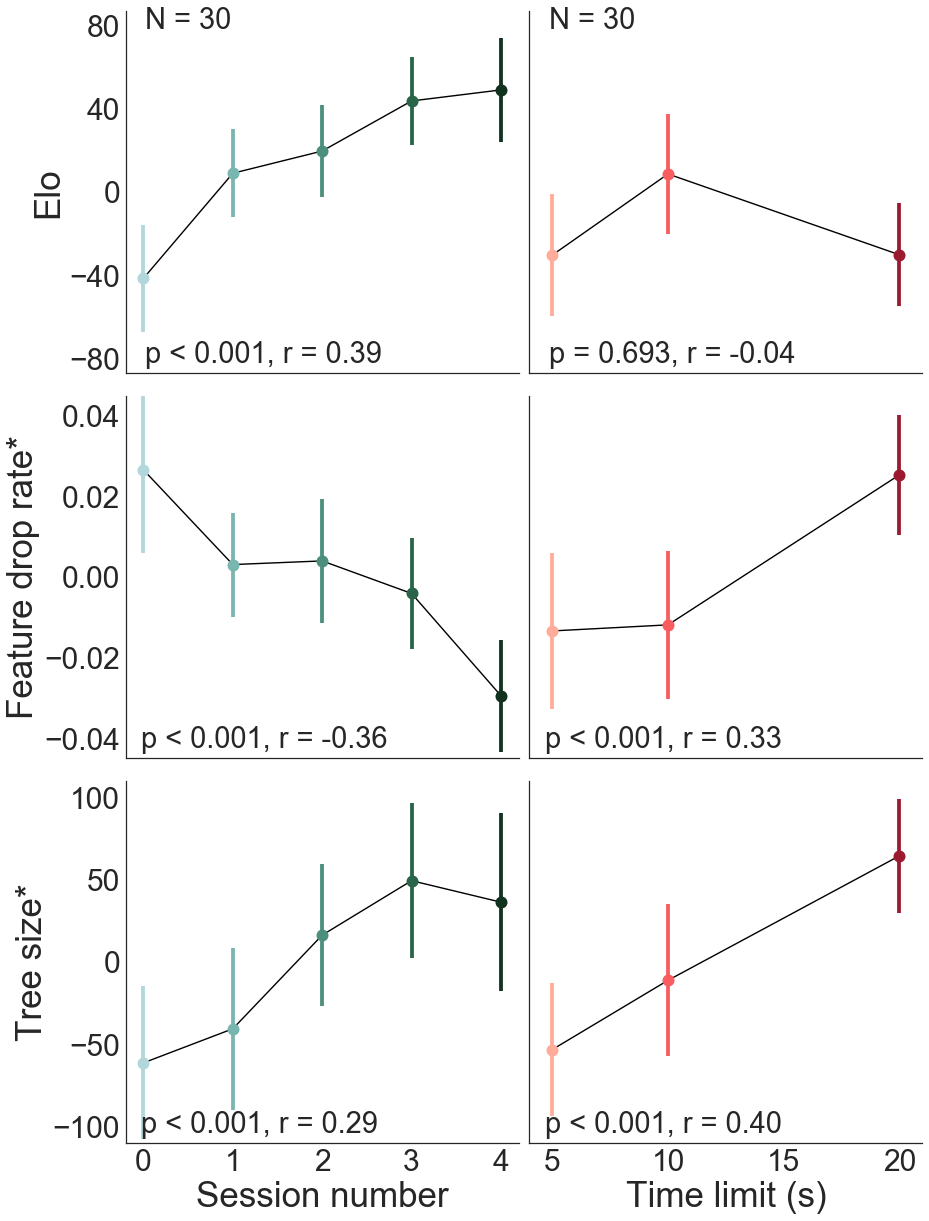

In [93]:
fig, axes = plt.subplots(3, 2, figsize=(13, 17))
variables = ordict([('Tree Size', 'mc tree_size'), ('Feature Drop Rate', 'mc attention')][::-1])
scatterkws['markersize'] = 12

for a, exp in enumerate([pl, pt]):
    ax = axes[0, a]
    div = divtypes[a]
    p = exp.groupby(div).mean().reset_index()
    p_sem = exp.groupby(div).sem().reset_index()
    ax.plot(p[div], p['elo'], color='black')
    
    for j, s in enumerate(p[div].unique()):
        if j==0:
            s0 = s
        _p = p.loc[p[div]==s, :]
        ax.plot(_p[div], _p['elo'], color=colorlist[a][j], **scatterkws)
        ax.errorbar(
            _p[div], _p['elo'], yerr=p_sem.loc[p_sem[div]==s, 'elo'], 
            color=colorlist[a][j], linewidth=3.8
        )
    
    res = stats.linregress(exp[div], exp['mc elo'])
    ax.text(.05, .95, "N = 30", fontsize=29, transform=ax.transAxes)
    ax.text(.05, .03, "p {} {:.3f}, r = {:.2f}".format(
            '=' if res.pvalue > .0005 else '<', 
            res.pvalue if res.pvalue > .0005 else .001, 
            res.rvalue), fontsize=29, transform=ax.transAxes
           )

plt.setp(axes[0, :], yticks=np.arange(-80, 81, 40), ylim=[-87, 87])
plt.setp(axes[0, 0], xlim=[-.25, 4.25], xticks=[], xticklabels=[], ylabel='Elo')
plt.setp(axes[0, 1], xlim=[4, 21], xticks=[], xticklabels=[])

for a, exp in enumerate([pl, pt]):
    for i, k in enumerate(variables.keys()):
        v = variables[k]
        ax = axes[i+1, a]
        div = divtypes[a]
        colors = [greens, reds][a]
        
        p = exp.groupby(div).mean().reset_index()
        p_sem = exp.groupby(div).sem().reset_index()
        ax.plot(p[div], p[v], color='black')
        
        for l, c in enumerate(p[div].unique()):
            _p = p.loc[p[div]==c]
            
            ax.plot(_p[div], _p[v], color=colors[l], label='none', **scatterkws)

            ax.errorbar(
                _p[div], _p[v], yerr=p_sem.loc[p_sem[div]==c, v]*1.96, linewidth=3.8, color=colors[l]
            )
            
        res = stats.linregress(exp[div], exp[v])
        ax.text(0.04, 0.03, 'p < {:.3f}, r = {:.2f}'.format(
                res.pvalue if res.pvalue > .0005 else .001, 
                res.rvalue), fontsize=29, transform=ax.transAxes)

plt.setp(axes[:, 0], xlim=[-.2, 4.2], xticks=np.arange(0, 4.1, 1))
plt.setp(axes[:, 1], xlim=[4, 21], xticks=np.arange(5, 21, 5), yticks=[])
plt.setp(axes[1, :], ylim=[-.045, .045], xticks=[])
plt.setp(axes[2, :], ylim=[-110, 110])

plt.setp(axes[1, 0], ylabel='Feature drop rate*', yticks=np.arange(-.04, .041, .02))
plt.setp(axes[2, 0], ylabel="Tree size*", xlabel='Session number', yticks=np.arange(-100, 101, 50))
plt.setp(axes[2, 1], xlabel='Time limit (s)')

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'Manip vs Params.png'))

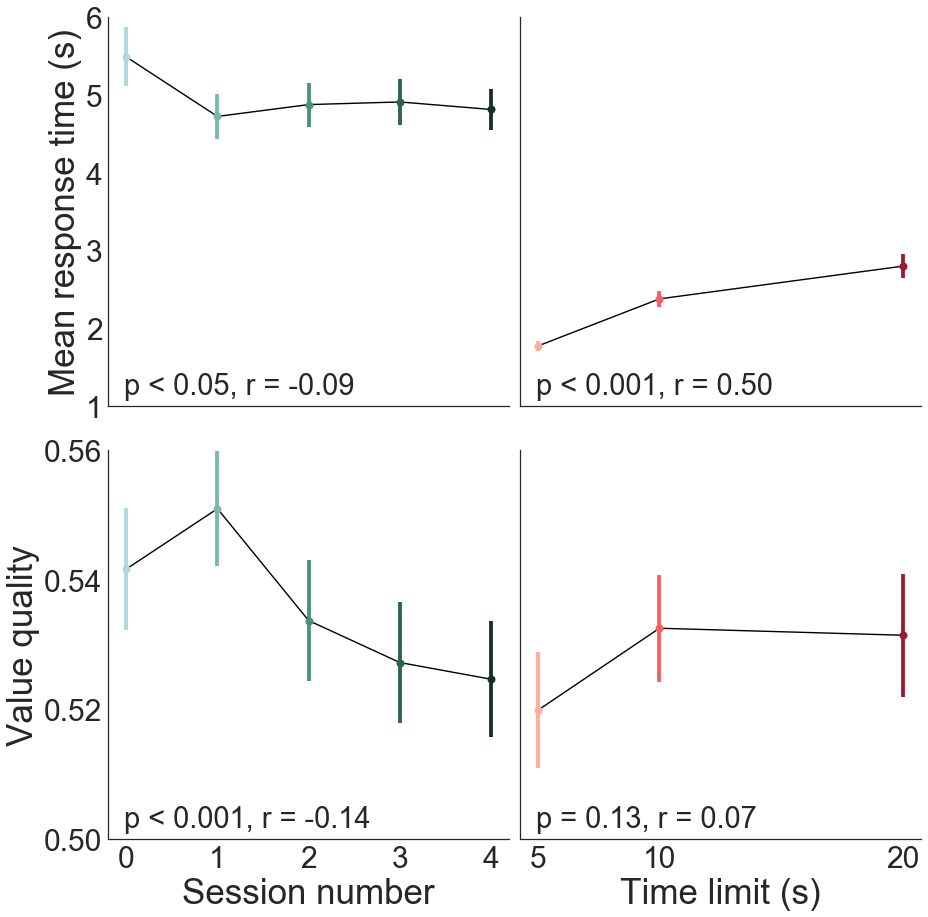

In [204]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharex=False, sharey=False)

scatterkws['markersize'] = 8
param1 = 'tree_size'
param2 = 'value_quality'

ax = axes[0, 0]
curve_like_plot('rt', 'learning', ax=ax, texton=True)
    
ax = axes[0, 1]
curve_like_plot('rt', 'timed', ax=ax, texton=True)

ax = axes[1, 0]
curve_like_plot(param2, 'learning', ax=ax, texton=True)
    
ax = axes[1, 1]
curve_like_plot(param2, 'timed', ax=ax, texton=True)

plt.setp(axes[0, :], ylim=[1, 6], xticks=[])
plt.setp(axes[1, :], ylim=[.5, .56])
plt.setp(axes[:, 1], yticks=[])
plt.setp(axes[0, 0], ylabel='Mean response time (s)')
plt.setp(axes[1, 0], ylabel='Value quality', xlabel='Session number', xticks=[0, 1, 2, 3, 4])
plt.setp(axes[1, 1], xlabel='Time limit (s)', xticks=[5, 10, 20])

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'vq and rt vs condition'))

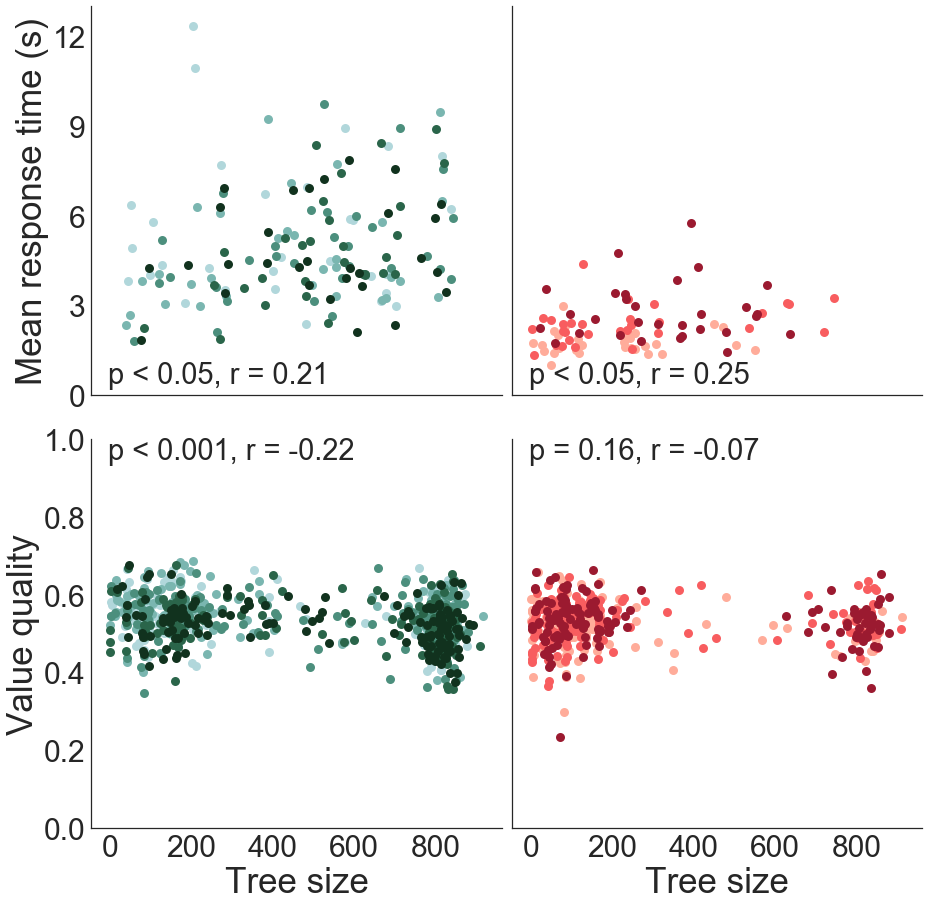

In [209]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), sharex=True)
## REMIX WITH VALQUAL FIG
scatterkws['markersize'] = 9

ax = axes[0, 0]
scatter_plot('tree_size', 'rt', 'learning', ax=ax, reduce=True, texton=True)

ax = axes[0, 1]
scatter_plot('tree_size', 'rt', 'timed', ax=ax, reduce=True, texton=True)

ax = axes[1, 0]
scatter_plot(param1, param2, 'learning', ax=ax, texton=True, textloc='top')  

ax = axes[1, 1]
scatter_plot(param1, param2, 'timed', ax=ax, texton=True, textloc='top')

plt.setp(axes[0, :], ylim=[0, 13], yticks=np.arange(0, 13, 3))
plt.setp(axes[1, :], ylim=[0, 1], xticks=np.arange(0, 1000, 200), xlabel='Tree size')
plt.setp(axes[0, 0], ylabel='Mean response time (s)')
plt.setp(axes[1, 0], ylabel='Value quality')
plt.setp(axes[:, 1], yticks=[])

sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(figdir, 'rt and vq vs tree size'))

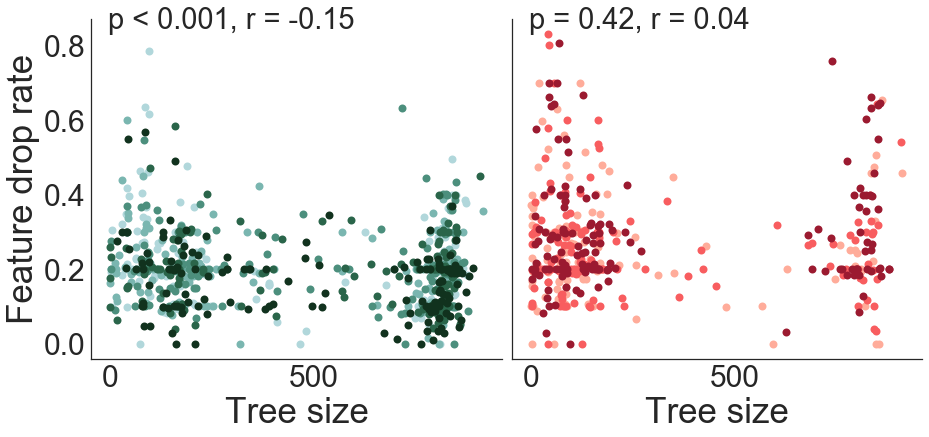

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)
param1 = 'tree_size'
param2 = 'attention'

ax = axes[0]
scatter_plot(param1, param2, 'learning', ax=ax, texton=True, textloc='top')

ax = axes[1]
scatter_plot(param1, param2, 'timed', ax=ax, texton=True, textloc='top')

plt.setp(axes, xlabel='Tree size')#, xticks=np.arange(0, 1000, 200))
plt.setp(axes[0], ylabel='Feature drop rate')#, ylim=[-.05, .9])

plt.tight_layout()
sns.despine()
fig.savefig(os.path.join(figdir, 'attn vs treesize.png'))

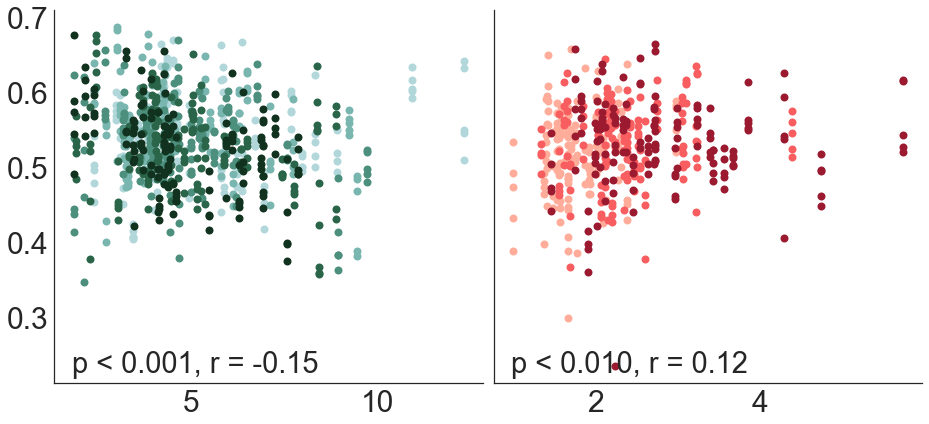

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
param1 = 'rt'
param2 = 'value_quality'

ax = axes[0]
scatter_plot(param1, param2, 'learning', ax=ax, texton=True)

ax = axes[1]
scatter_plot(param1, param2, 'timed', ax=ax, texton=True)

plt.tight_layout()
sns.despine()

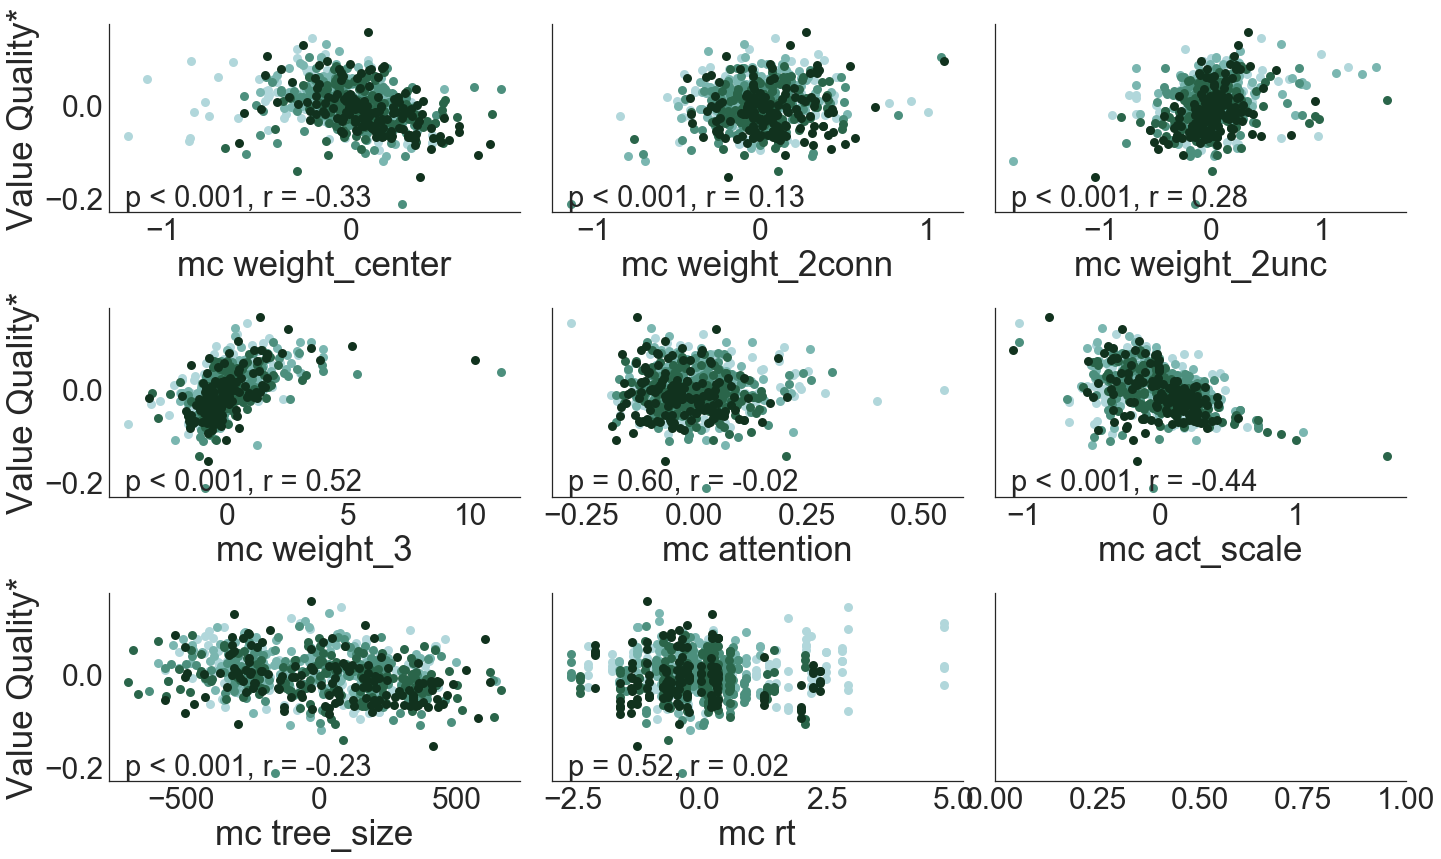

In [213]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12), sharey=True)
for j, w in enumerate(['mc weight_center', 'mc weight_2conn', 'mc weight_2unc', 
                       'mc weight_3', 'mc attention', 'mc act_scale',
                       'mc tree_size', 'mc rt']):
    ax = axes.flatten()[j]
    scatter_plot(w, 'mc value_quality', 'learning', ax=ax, texton=True)
    plt.setp(ax, xlabel=w)
    
plt.setp(axes[:, 0], ylabel='Value Quality*')
plt.tight_layout()
sns.despine()

# Parameters Learning

In [7]:
L = pd.read_csv(os.path.join(gdpath, 'Data/3_lrn/Clean/_summaries/all_games_all_fields.csv'))
A = pd.read_csv(os.path.join(gdpath, 'Data/3_lrn/Clean/_summaries/all_afc2s_all_fields.csv'))

A['correct'] = 1
A.loc[(A.aval > A.bval) & (A.response == A.b), 'correct'] = 0
A.loc[(A.bval > A.aval) & (A.response == A.a), 'correct'] = 0
T = A.loc[A.aval != A.bval, :]

ranks = pd.read_csv(os.path.join(gdpath, 'Analysis/3_lrn/ratings_learn.csv'))
R = ranks.loc[ranks['Subject'] >= 0, :]
for s in R.Subject.unique():
    _r = R.loc[R.Subject == s, :]
    _g = _r.sort_values('Session').games.cumsum()
    
    R.loc[_g.index, 'games td'] = _g.values
R = R.sort_values(['Subject', 'Session'])

for s in R.Subject.unique():
    for ss in R.Session.unique():
        R.loc[(R.Subject==s)&(R.Session==ss), 'mean rt'] = L.loc[(L.subject==s)&(L.session==ss), 'rt'].mean()
        if ss%2 == 0:
            R.loc[(R.Subject==s)&(R.Session==ss), 'afc score'] = T.loc[(T.subject==s)&(T.session==ss), 'correct'].mean()

ratings = pd.read_csv(os.path.join(gdpath, 'Analysis/5_tai/ratings_tai (6).csv'))
ratings['Subject'] = ratings['Name'].map(lambda x: int(x[3:5]) if len(x) == 11 else np.nan)
ratings['condition'] = ratings['Name'].map(lambda x: int(x[-2:]) if len(x) == 11 else np.nan)
ratings = ratings.sort_values(['Subject', 'condition'])

/Users/gianni/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


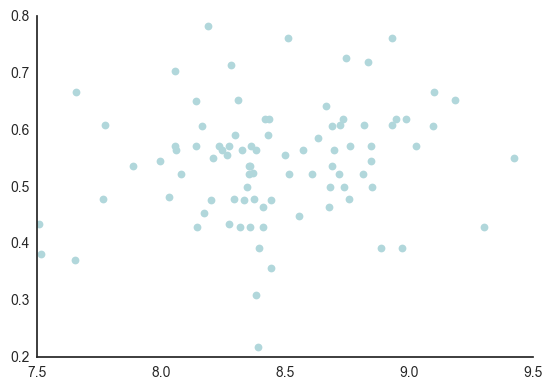

In [29]:
plt.plot(np.log(R['mean rt']), R['afc score'], linestyle='none', marker='o')
sns.despine()